In [1]:
WIDTH = 320
HEIGHT = 240
EPOCHS = 8
BATCH_SIZE = 8
TRAIN_CSV = "D:/dataset/train/data_train.csv"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

%run utils/datasets.ipynb
%run utils/utils.ipynb

In [3]:
partition, labels = load_train_csv(TRAIN_CSV)

In [4]:
partition['train'] = partition['train'][:20000]
partition['validation'] = partition['validation'][:5000]

In [5]:
print(len(partition['train']), len(partition['validation']))

7532 1884


In [6]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE,
                                   dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE,
                                     dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [7]:
def downsampling_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
    x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = concatenate([x, concat_with], axis=3)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

In [8]:
def build(height, width, depth):
    # input
    i = Input(shape=(height, width, depth))

    # encoder
    conv1 = downsampling_block(i, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = downsampling_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = downsampling_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = downsampling_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # decoder
    conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
    conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
    conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
    conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)
    
    # output
    o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

    model = Model(inputs=i, outputs=o)
    return model

In [9]:
model = build(HEIGHT, WIDTH, 3)

In [10]:
model.compile(optimizer=opt,
              loss=lambda y_true, y_pred : gen_depth_loss(y_true, y_pred, (1.0,1.0,0.1)),
              metrics=[depth_acc])

In [11]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LEARNING_RATE
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [12]:
r = model.fit(training_generator, validation_data=validation_generator,
              epochs=EPOCHS, callbacks=[LearningRateScheduler(poly_decay)])

Epoch 1/8
941/941 [==============================] - 422s 440ms/step - loss: 0.4155 - depth_acc: 0.7480 - val_loss: 0.3979 - val_depth_acc: 0.7778 - lr: 1.0000e-04
Epoch 2/8
941/941 [==============================] - 414s 440ms/step - loss: 0.3837 - depth_acc: 0.8090 - val_loss: 0.3808 - val_depth_acc: 0.8258 - lr: 8.7500e-05
Epoch 3/8
941/941 [==============================] - 414s 440ms/step - loss: 0.3747 - depth_acc: 0.8275 - val_loss: 0.3758 - val_depth_acc: 0.8276 - lr: 7.5000e-05
Epoch 4/8
941/941 [==============================] - 414s 440ms/step - loss: 0.3693 - depth_acc: 0.8344 - val_loss: 0.3767 - val_depth_acc: 0.8296 - lr: 6.2500e-05
Epoch 5/8
941/941 [==============================] - 416s 442ms/step - loss: 0.3649 - depth_acc: 0.8411 - val_loss: 0.3684 - val_depth_acc: 0.8389 - lr: 5.0000e-05
Epoch 6/8
941/941 [==============================] - 415s 441ms/step - loss: 0.3608 - depth_acc: 0.8467 - val_loss: 0.3657 - val_depth_acc: 0.8438 - lr: 3.7500e-05
Epoch 7/8
941/94

In [13]:
print(r.history)

{'loss': [0.4155324697494507, 0.38365212082862854, 0.37472325563430786, 0.3692755401134491, 0.3648812472820282, 0.36079514026641846, 0.35759785771369934, 0.35471951961517334], 'depth_acc': [0.7479891180992126, 0.8090295195579529, 0.8274760842323303, 0.8344205617904663, 0.8411181569099426, 0.8466567397117615, 0.8499728441238403, 0.8525952696800232], 'val_loss': [0.397914856672287, 0.380764901638031, 0.37576091289520264, 0.3767492473125458, 0.3683951199054718, 0.3656909167766571, 0.36405372619628906, 0.3605172634124756], 'val_depth_acc': [0.7778262495994568, 0.8258376717567444, 0.8276231288909912, 0.829626739025116, 0.8389207124710083, 0.8437623381614685, 0.8428316712379456, 0.8467254638671875], 'lr': [1e-04, 8.75e-05, 7.5e-05, 6.25e-05, 5e-05, 3.75e-05, 2.5e-05, 1.25e-05]}


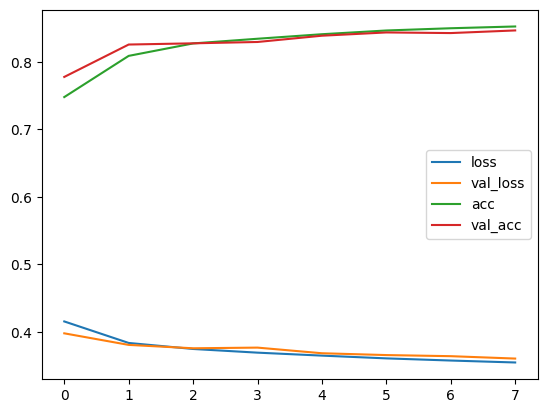

In [14]:
plot_history(r.history)

In [15]:
print(save_model('unet_custom_dataset', model))

model_unet_custom_dataset_1719536196.keras
